In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix

from textblob import TextBlob

#Dataset

In [3]:
df = pd.read_csv('sentiment_tweets3.csv')

In [4]:
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [5]:
len(df)

10314

In [6]:
df = df.drop(['Index'], axis = 'columns')
df = df.drop_duplicates(keep = 'first')
print("The size of dataset after removing duplicates is : ", len(df))

The size of dataset after removing duplicates is :  10283


In [7]:
df

,message to examine,label (depression result)
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


Negative Sentiment Tweets Percentage is 77.75940873286007%
Positive Sentiment Tweets Percentage is 22.24059126713994%


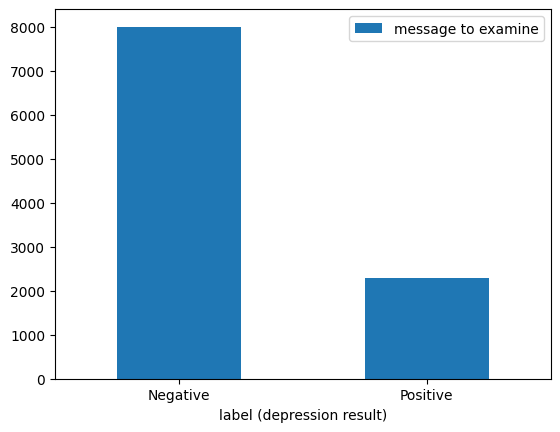

In [8]:
pltbar = df.groupby('label (depression result)').count().plot(kind='bar')
pltbar.set_xticklabels(['Negative','Positive'], rotation=0)


#Calculating percentages of negative and positive tweets
positiveTweets = 100*len(df.loc[df['label (depression result)']==1,'label (depression result)'])/len(df['label (depression result)'])
negativeTweets = 100*len(df.loc[df['label (depression result)']==0,'label (depression result)'])/len(df['label (depression result)'])
print(f'Negative Sentiment Tweets Percentage is {negativeTweets}%')
print(f'Positive Sentiment Tweets Percentage is {positiveTweets}%')

In [9]:
text = list(df['message to examine'])
sentiment = list(df['label (depression result)'])

In [10]:
stop_words = stopwords.words('english')
def cleanTweet(text):
    cleanedTweets = []
    
    for tweets in text:
        #Converting text to lowercase
        tweets = tweets.lower()

        #Removing newline breaks
        tweets = re.sub(r'\n', '', tweets)
        
        #Removing URLs
        tweets = re.sub(r"(?:\|http?\://|https?\://|www)\S+", "", tweets)
        
        #Removing @usernames
        tweets = re.sub('@[^\s]+','', tweets)
        
        #Removing punctuations, numbers & special characters
        tweets = re.sub("[^a-zA-Z]", " ", tweets)
        
        #Removing emojis
        tweets = re.compile("["
                   u"U0001F600-U0001F64F"  # emoticons
                   u"U0001F300-U0001F5FF"  # symbols & pictographs
                   u"U0001F680-U0001F6FF"  # transport & map symbols
                   u"U0001F1E0-U0001F1FF"  # flags (iOS)
                   u"U00002702-U000027B0"
                   u"U000024C2-U0001F251"
                               "]+", flags=re.UNICODE).sub(r'', tweets)
        
        finaltweet = ''
        #Removing short words(with length less than 3) & stop words
        temp = tweets.split()
        stop_words = stopwords.words('english')
        stop_words = stop_words + ['hi', 'im', 'amp', 'quot']
        textwithoutstopwords = [word for word in temp if not word in stop_words and len(word)>2]
        
        #Lemmatization
        lem = WordNetLemmatizer()
        lemmatizedText = [lem.lemmatize(y) for y in textwithoutstopwords]
        finaltweet = ' '.join(lemmatizedText)
        cleanedTweets.append(finaltweet)
    return cleanedTweets

In [11]:
cleanedTweets = cleanTweet(text)
df['Cleaned Tweets'] = cleanedTweets
df

,message to examine,label (depression result),Cleaned Tweets
0,just had a real good moment. i missssssssss hi...,0,real good moment miss much
1,is reading manga http://plurk.com/p/mzp1e,0,reading manga
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,
3,@lapcat Need to send 'em to my accountant tomo...,0,need send accountant tomorrow oddly even refer...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add myspace myspace com lookthunder
...,...,...,...
10309,No Depression by G Herbo is my mood from now o...,1,depression herbo mood done stressing people de...
10310,What do you do when depression succumbs the br...,1,depression succumbs brain make feel like never...
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamine nasal spray show promise depression s...
10312,dont mistake a bad day with depression! everyo...,1,dont mistake bad day depression everyone


#Splitting Data

In [12]:
X_train,X_test,Y_train, Y_test = train_test_split(text, sentiment, test_size=0.1)
print("Size of training set : ", len(X_train))
print("Size of test set : ", len(X_test))

Size of training set :  9254
Size of test set :  1029


#TF-IDF Vectorizer

In [13]:
vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=5000000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

###Calculating model accuracies

In [14]:
def evaluateModel(model):
    
    #Predict values for test dataset
    Y_pred = model.predict(X_test)

    #Print the accuracy score and f1 score
    print("Accuracy = ",accuracy_score(Y_test,Y_pred))
    print("f1-score = ",f1_score(Y_test, Y_pred))
    
    
#Function to plot the confusion matrix    
def plotCF(model):
    Y_pred = model.predict(X_test)
    
    #Plotting the confusion matrix
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Negatives','False Positives', 'False Negatives','True Positives']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGnBu',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

####1.Logistic Regression

Logistic Regression : 
Accuracy =  0.9951409135082604
f1-score =  0.9888641425389755


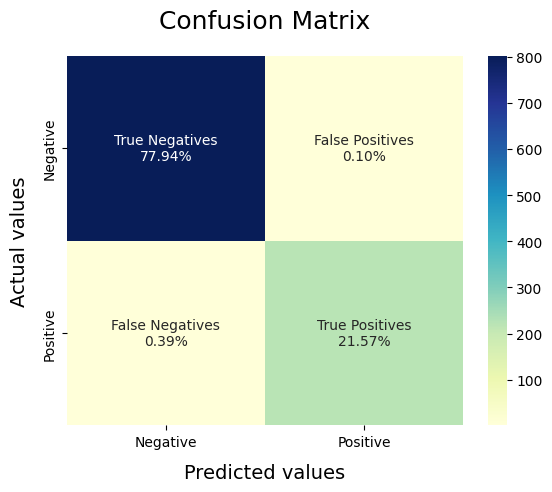

In [15]:
lr = LogisticRegression(max_iter = 10000, n_jobs=-1)
lr.fit(X_train, Y_train)
print("Logistic Regression : ")
evaluateModel(lr)
plotCF(lr)

####2.Bernoulli Naive Bayes

Bernoulli Naive Bayes Model : 
Accuracy =  0.8775510204081632
f1-score =  0.6134969325153374


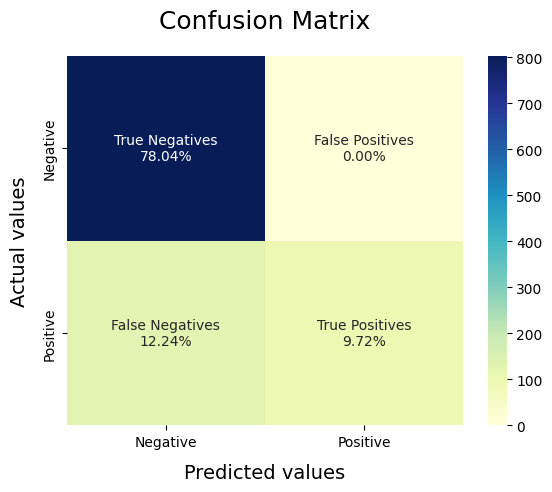

In [16]:
bnb = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bnb.fit(X_train, Y_train)
print("Bernoulli Naive Bayes Model : ")
evaluateModel(bnb)
plotCF(bnb)

####3. Multinomial Naive Bayes

Multinomial Naive Bayes Model : 
Accuracy =  0.8901846452866861
f1-score =  0.6666666666666666


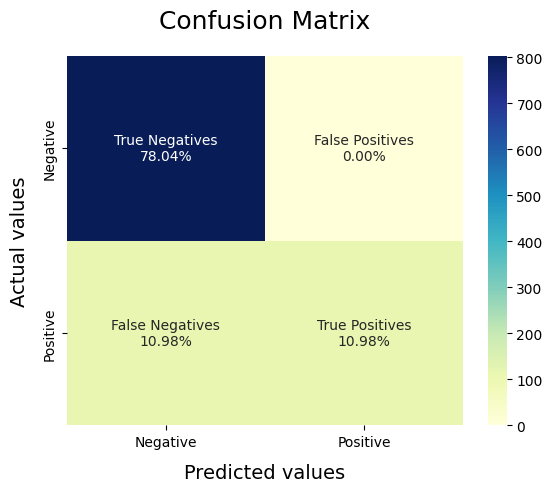

In [17]:
mnb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
mnb.fit(X_train, Y_train)
print("Multinomial Naive Bayes Model : ")
evaluateModel(mnb)
plotCF(mnb)

####4.Support Vector Machine

Support Vector Machine :
Accuracy =  0.9990281827016521
f1-score =  0.9977827050997783


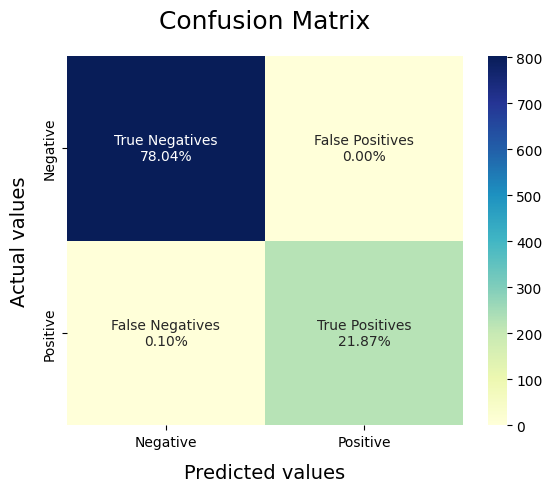

In [18]:
svm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=10000)
svm.fit(X_train, Y_train)
print("Support Vector Machine :")
evaluateModel(svm)
plotCF(svm)

#Saving Model

In [28]:
#Saving the model
file = open('deplr.pickle','wb')
pickle.dump(svm, file)
file.close()

In [21]:
#Saving the vectorizer
file = open('depvectorizer.pickle','wb')
pickle.dump(vectorizer, file)
file.close()

####Load And Test

In [29]:
def loadModel():    
    #Load the vectoriser.
    file = open('depvectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    #Load the model
    file = open('deplr.pickle', 'rb')
    model = pickle.load(file)
    file.close()
    return vectorizer, model



def predict(vectorizer, model, text):
    #Predict the sentiment
    inputdata = vectorizer.transform(cleanTweet(text))
    sentiment = model.predict(inputdata)
    
    # Make a list of text with sentiment.
    input = []
    for text, pred in zip(text, sentiment):
        input.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df1 = pd.DataFrame(input, columns = ['Tweets','Sentiment'])
    df1 = df1.replace([0,1], ["Negative","Positive"])
    return df1



#Loading the saved model
vectorizer, model = loadModel()
#tweets whose sentiments are to be predicted
text = ["This was the worst trip I have ever had in my life.",
            "I like pizza",
            "Heppi",
            "Read Manga",
            "Cringe",
            "He wished to sleep, but he knew he would not be able to and that most happy thoughts came to him in bed",
            "lmao u got it", 
            "bit stuffing"]

df = predict(vectorizer, model, text)
df 

,Tweets,Sentiment
0,This was the worst trip I have ever had in my ...,Negative
1,I like pizza,Negative
2,Heppi,Negative
3,Read Manga,Negative
4,Cringe,Negative
5,"He wished to sleep, but he knew he would not b...",Negative
6,lmao u got it,Negative
7,bit stuffing,Negative
